In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os.path
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
sentTrain = pd.read_csv('generic_sentiment_dataset_50k.csv')
display(sentTrain.head())
display(sentTrain.shape)

,sentiment,text,label
0,positive,good mobile. battery is 5000 mah is very big. ...,2
1,positive,Overall in hand ecpirience is quite good matt ...,2
2,positive,"1. Superb Camera,\r\n2. No lag\r\n3. This is m...",2
3,positive,Bigger size of application names doesn't allow...,2
4,negative,Just a hype of stock android which is not flaw...,0


(50000, 3)

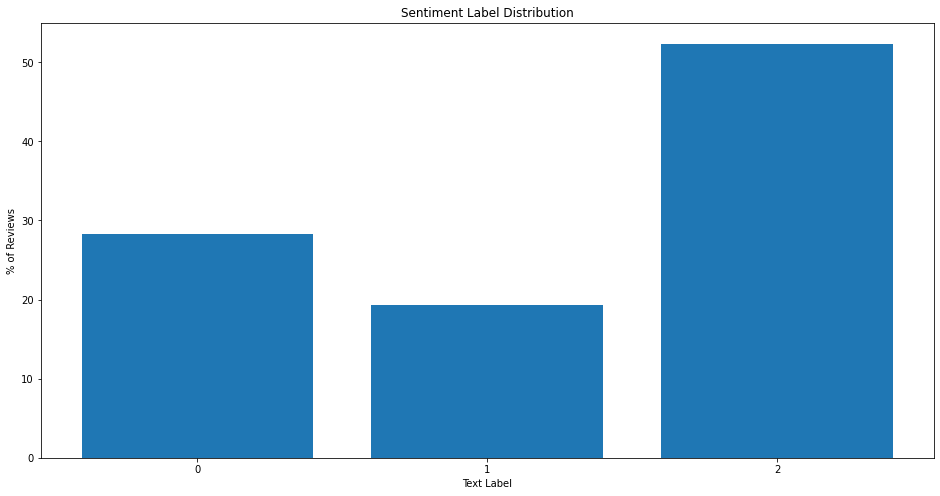

In [3]:
values, counts = np.unique(sentTrain['label'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure(figsize = (16,8))
plt.bar(values, normalized_counts*100)
plt.xlabel('Text Label')
plt.xticks([0,1,2])
plt.ylabel('% of Reviews')
plt.title("Sentiment Label Distribution")
plt.show()

In [4]:
# Provided to me during my Data Science diploma program

ENGLISH_STOP_WORDS = stopwords.words('english')

def customTokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    stemmer = nltk.stem.PorterStemmer()
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [5]:
X = sentTrain['text']
y = sentTrain['label']

In [6]:
if (os.path.exists('preRunModels/sentWordsVec.joblib')):
    sentWordsVec = joblib.load('preRunModels/sentWordsVec.joblib')
else:
    sentWordsVec = CountVectorizer(min_df = 75, 
                                   tokenizer = customTokenizer,
                                   ngram_range = (1,3))
    
    # Save the model result lists for loading in the futrure
    joblib.dump(sentWordsVec, 'preRunModels/sentWordsVec.joblib')
    
sentWordsVec.fit(X)
X_Vec = sentWordsVec.transform(X)

In [7]:
if (os.path.exists('preRunModels/sentWordsIdf.joblib')):
    sentWordsIdf = joblib.load('preRunModels/sentWordsIdf.joblib')
else:
    sentWordsIdf = TfidfVectorizer(min_df = 75, 
                                   tokenizer = customTokenizer,
                                   ngram_range = (1,3),
                                   strip_accents = 'ascii')
    # Save the model result lists for loading in the futrure
    joblib.dump(sentWordsIdf, 'preRunModels/sentWordsIdf.joblib')
    
sentWordsIdf.fit(X)
X_Idf = sentWordsIdf.transform(X)

In [8]:
VecDF = pd.DataFrame(columns = sentWordsVec.get_feature_names(), data = X_Vec.toarray())
VecDF['label'] = y
display(VecDF)

,\r\n\r\ni,\r\n\r\nthe,0,1,1 day,1 month,10,10 day,100,10000,...,your,youtub,yummi,zoom,…,🇺🇸,🇺🇸 gopdeb,🇺🇸 gopdeb gopdeb,👍,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
check = VecDF.loc[0]
check.where(check > 0, inplace = True)
check.dropna(inplace = True)
print(check)
print()
print(f"Original Text: {sentTrain.iloc[0,1]}")
print(f"Original Label: {sentTrain.iloc[0,2]}")

5000                   1.0
5000 mah               1.0
batteri                1.0
big                    1.0
camera                 1.0
camera qualiti         1.0
camera qualiti good    1.0
good                   2.0
good mobil             1.0
mah                    1.0
mobil                  1.0
qualiti                1.0
qualiti good           1.0
label                  2.0
Name: 0, dtype: float64

Original Text: good mobile. battery is 5000 mah is very big. camera quality very good.
Original Label: 2


In [10]:
def plot_most_frequent(words, word_counts, top=20):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(16,8))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token")\
        .plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens")
    plt.show()
    
    return words_df

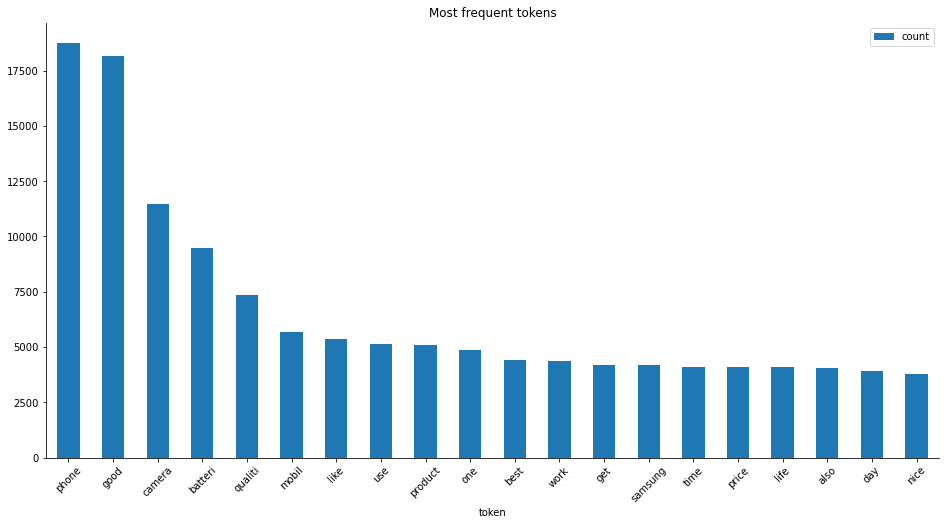

In [11]:
wordCountsVec = X_Vec.toarray().sum(axis=0)
wordsVec = sentWordsVec.get_feature_names()

wordsVecDF = plot_most_frequent(wordsVec, wordCountsVec)

In [12]:
IdfDF = pd.DataFrame(columns = sentWordsIdf.get_feature_names(), data = X_Idf.toarray())
IdfDF['label'] = y
display(IdfDF)

,\r\n\r\ni,\r\n\r\nthe,0,1,1 day,1 month,10,10 day,100,10000,...,year,yelp,yesterday,yet,youll,your,youtub,yummi,zoom,label
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.252649,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
49996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
49997,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
49998,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
check = IdfDF.loc[0]
check.where(check > 0, inplace = True)
check.dropna(inplace = True)
print(check)
print()
print(f"Original Text: {sentTrain.iloc[0,1]}")
print(f"Original Label: {sentTrain.iloc[0,2]}")

5000                   0.359667
5000 mah               0.378035
batteri                0.160454
big                    0.300573
camera                 0.153798
camera qualiti         0.224137
camera qualiti good    0.318046
good                   0.260738
good mobil             0.333613
mah                    0.327722
mobil                  0.195968
qualiti                0.175102
qualiti good           0.284338
label                  2.000000
Name: 0, dtype: float64

Original Text: good mobile. battery is 5000 mah is very big. camera quality very good.
Original Label: 2


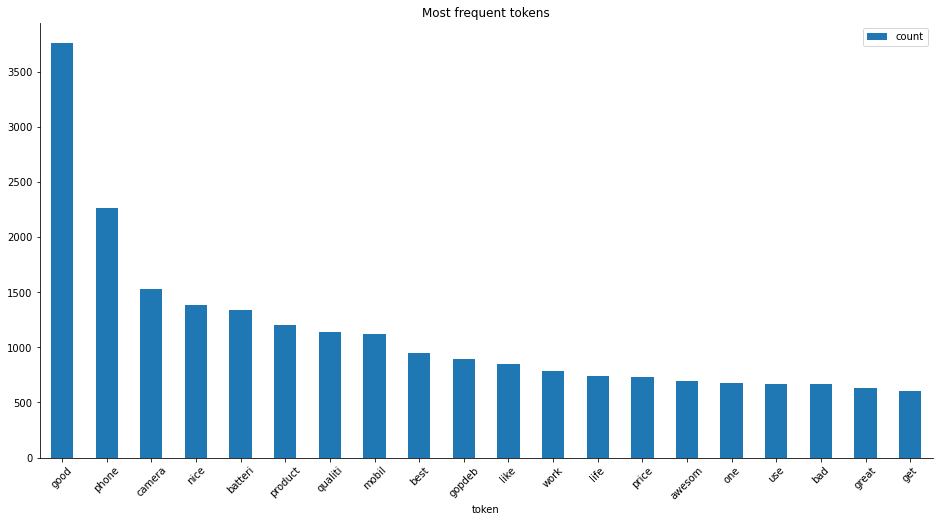

In [14]:
wordCountsIdf = X_Idf.toarray().sum(axis=0)
wordsIdf = sentWordsIdf.get_feature_names()

wrodsDF = plot_most_frequent(wordsIdf, wordCountsIdf)

In [15]:
XVec = VecDF.iloc[:, :-1]
yVec = VecDF.iloc[:,-1]
print(f"Shapes: {XVec.shape, yVec.shape}")

Shapes: ((50000, 1650), (50000,))


In [16]:
X_trainVec, X_valVec, y_trainVec, y_valVec = train_test_split(XVec, yVec, test_size=0.33, random_state=12)
print(f"Train Shapes: {X_trainVec.shape, y_trainVec.shape}")
print(f"Val Shapes: {X_valVec.shape, y_valVec.shape}")

Train Shapes: ((33500, 1650), (33500,))
Val Shapes: ((16500, 1650), (16500,))


In [17]:
valScores = []
trainScores = []
cVals = []
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/valScores.joblib') & os.path.exists('preRunModels/trainScores.joblib') & os.path.exists('preRunModels/cVals.joblib')):
    valScores = joblib.load('preRunModels/valScores.joblib')
    trainScores = joblib.load('preRunModels/trainScores.joblib')
    cVals = joblib.load('preRunModels/cVals.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    for c in C_range:
        my_logreg = LogisticRegression(solver='lbfgs', C = c, random_state = 12)
        my_logreg.fit(X_trainVec, y_trainVec)

        trainScores.append(my_logreg.score(X_trainVec, y_trainVec))
        valScores.append(my_logreg.score(X_valVec, y_valVec))
        cVals.append(c)
    
        # Print progress through the loop
        print(f"C={c}", end="\r")
        
    # Save the model result lists for loading in the futrure
    joblib.dump(valScores, 'preRunModels/valScores.joblib')
    joblib.dump(trainScores, 'preRunModels/trainScores.joblib')
    joblib.dump(cVals, 'preRunModels/cVals.joblib')
        
bestCValVec = cVals[np.argmax(valScores)]

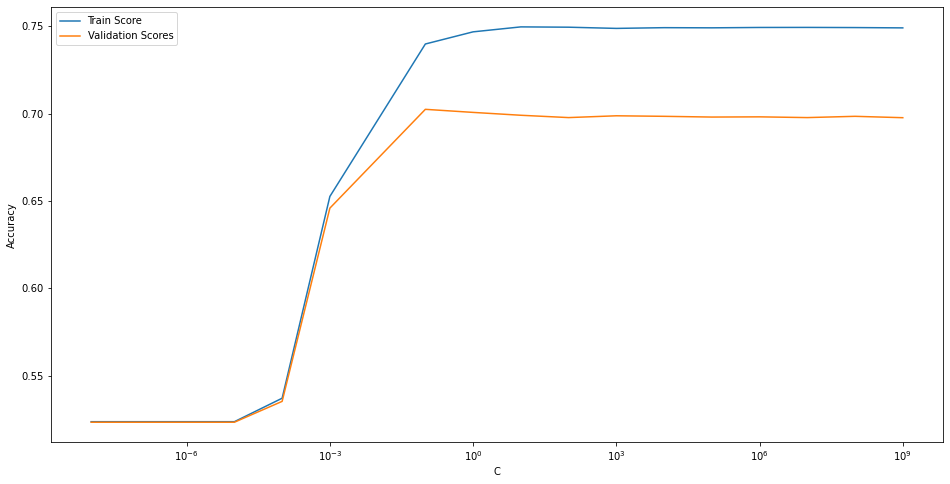

The c-calue with the highest valuation score is 0.1


In [18]:
plt.figure(figsize = (16,8))
plt.plot(C_range, trainScores,label="Train Score")
plt.plot(C_range, valScores,label="Validation Scores")
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-calue with the highest valuation score is {bestCValVec}")

In [19]:
%%time
logitVec = LogisticRegression(solver='lbfgs', C = bestCValVec, random_state = 12)

logitVec.fit(X_trainVec, y_trainVec)

print(f"Logestical Regression Train: {logitVec.score(X_trainVec, y_trainVec)}")
print(f"Logestical Regression Valuation: {logitVec.score(X_valVec, y_valVec)}")

Logestical Regression Train: 0.7398805970149254
Logestical Regression Valuation: 0.7024848484848485
Wall time: 13.6 s


In [20]:
XIdf = IdfDF.iloc[:, :-1]
yIdf = IdfDF.iloc[:,-1]
print(f"Shapes: {XIdf.shape, yIdf.shape}")

Shapes: ((50000, 1647), (50000,))


In [21]:
X_trainIdf, X_valIdf, y_trainIdf, y_valIdf = train_test_split(XIdf, yIdf, test_size=0.33, random_state=12)
print(f"Train Shapes: {X_trainIdf.shape, y_trainIdf.shape}")
print(f"Val Shapes: {X_valIdf.shape, y_valIdf.shape}")

Train Shapes: ((33500, 1647), (33500,))
Val Shapes: ((16500, 1650), (16500,))


In [22]:
valScores2 = []
trainScores2 = []
cVals2 = []
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/valScores2.joblib') & os.path.exists('preRunModels/trainScores2.joblib') & os.path.exists('preRunModels/cVals2.joblib')):
    valScores2 = joblib.load('preRunModels/valScores2.joblib')
    trainScores2 = joblib.load('preRunModels/trainScores2.joblib')
    cVals2 = joblib.load('preRunModels/cVals2.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    for c in C_range:
        my_logreg = LogisticRegression(solver='lbfgs', C = c, random_state = 12)
        my_logreg.fit(X_trainIdf, y_trainIdf)

        trainScores2.append(my_logreg.score(X_trainIdf, y_trainIdf))
        valScores2.append(my_logreg.score(X_valIdf, y_valIdf))
        cVals2.append(c)
    
        # Print progress through the loop
        print(f"C={c}", end="\r")
        
    # Save the model result lists for loading in the futrure
    joblib.dump(valScores2, 'preRunModels/valScores2.joblib')
    joblib.dump(trainScores2, 'preRunModels/trainScores2.joblib')
    joblib.dump(cVals2, 'preRunModels/cVals2.joblib')
        
bestCValIdf = cVals2[np.argmax(valScores2)]

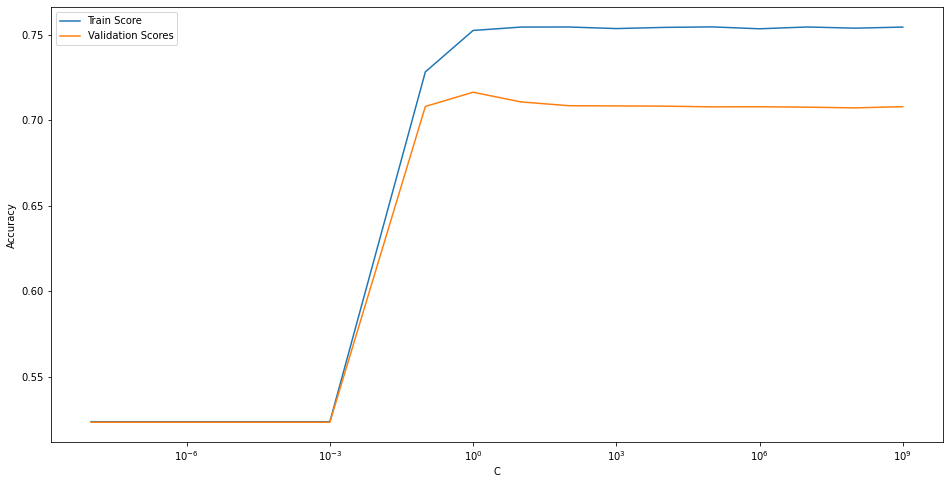

The c-calue with the highest valuation score is 1.0


In [24]:
plt.figure(figsize = (16,8))
plt.plot(C_range, trainScores2, label="Train Score")
plt.plot(C_range, valScores2, label="Validation Scores")
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-calue with the highest valuation score is {bestCValIdf}")

In [25]:
%%time
logitIdf = LogisticRegression(solver='lbfgs', C = bestCValIdf, random_state = 12)

logitIdf.fit(X_trainIdf, y_trainIdf)

print(f"Logestical Regression Train: {logitIdf.score(X_trainIdf, y_trainIdf)}")
print(f"Logestical Regression Valuation: {logitIdf.score(X_valIdf, y_valIdf)}")

Logestical Regression Train: 0.7524179104477612
Logestical Regression Valuation: 0.7163030303030303
Wall time: 13.8 s


Add PCA and CV   
SVC   
KNN   
DT   

In [30]:
vecPcaCheck = PCA(n_components = X_trainVec.shape[1])
vecPcaCheck.fit(X_trainVec)

explVar = vecPCACheck.explained_variance_ratio_.cumsum()
np.where((explVar >= 0.9) & (explVar <= 0.91))

(array([750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762,
        763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775,
        776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
        789, 790, 791, 792, 793, 794, 795, 796, 797], dtype=int64),)

In [32]:
vecPCA = PCA(n_components=750)

vecPCA.fit(X_trainVec)

XVecTrainPCA = vecPCA.transform(X_trainVec)
XVecValPCA = vecPCA.transform(X_valVec)

In [33]:
logitVec.fit(XVecTrainPCA, y_trainVec)

print(f"Logestical Regression Train: {logitVec.score(XVecTrainPCA, y_trainVec)}")
print(f"Logestical Regression Valuation: {logitVec.score(XVecValPCA, y_valVec)}")

Logestical Regression Train: 0.722089552238806
Logestical Regression Valuation: 0.6971515151515152


In [34]:
idfPcaCheck = PCA(n_components = X_trainIdf.shape[1])
idfPcaCheck.fit(X_trainIdf)

explVar = idfPcaCheck.explained_variance_ratio_.cumsum()
np.where((explVar >= 0.9) & (explVar <= 0.91))

(array([ 981,  982,  983,  984,  985,  986,  987,  988,  989,  990,  991,
         992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001, 1002,
        1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
        1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022], dtype=int64),)

In [35]:
idfPCA = PCA(n_components=981)

idfPCA.fit(X_trainIdf)

XIdfTrainPCA = idfPCA.transform(X_trainIdf)
XIdfValPCA = idfPCA.transform(X_valIdf)

In [36]:
logitIdf.fit(XIdfTrainPCA, y_trainIdf)

print(f"Logestical Regression Train: {logitIdf.score(XIdfTrainPCA, y_trainIdf)}")
print(f"Logestical Regression Valuation: {logitIdf.score(XIdfValPCA, y_valIdf)}")

Logestical Regression Train: 0.7407462686567164
Logestical Regression Valuation: 0.7137575757575758
